## **Python class for preprocessing two-photon imaging data and example usages**

* Read image files recorded by ScanImage and demultiplex the images into green and red channel.

* Filter images with gaussian filter (of specified kernel size).

* Subpixel image motion correcion using FFT.

* Use end-of-the-frame signals for two-photon images and IR high-speed camera images to synchronize the two imaging stream.

* Make a movie that shows two-photon images (both green and red channel) and IR high-speed camera images simultaneously for quick review.



---
* *This example Jupyter notebook is set to run on google colab using data on google drive.*
* *Parameters in the .yaml files are set for downstairs two-photon microscope.*

### Install ScanImage Tiff Reader provided by Vidriotech

In [1]:
#Install ScanImage Tiff Reader for Python
!pip install scanimage-tiff-reader

     |████████████████████████████████| 993kB 7.6MB/s 
  Created wheel for scanimage-tiff-reader: filename=scanimage_tiff_reader-1.4.1-cp37-cp37m-manylinux1_x86_64.whl size=1010326 sha256=5438d977c7a82ffc4969d8ba685eb36201fe722e96c82ac692b832571f1d049d
  Stored in directory: /root/.cache/pip/wheels/f7/f5/c8/1d26877e58dfee4432ebd28d53525118bd88ab46bac710cd3a
Successfully built scanimage-tiff-reader


### For image registration, re-install the updated package of scikit-image.

* Currently, google colab has verion 0.16 installed. We need at least 0.17.

In [2]:
!pip install -U scikit-image

     |████████████████████████████████| 29.2MB 104kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2


### Mount the Google Drive (Shared drives)
* Here we assume that the data files are on google drive

In [3]:
#link to the google drive. Need to follow the authorization instructions.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### A python class for preprocessing two-photon images

* **filter_ScanImageFile_singleZ**: load ScanImage file, demultiplex the data into green and red channel, filter images with gaussian filter.

* **motion_correction**: correct for motion artifact at subpixel resolution using FFT.

* **detect_camera_imaging_frames2**: use frame signals and mirro signals recorded for the two-photon image and IR high-speed camera to synchronize the two imaging streams.

* **make_synchronized_video_gray**: make a video that shows two-photon images (both green and red channel) and IR high-speed camera images simultaneously for a quick review of the data.

* **make_synchronized_video_gray_piezo**: same as above, but for piezo experiments (does not have IR high-speed camera images). 

* parameters are set in .yaml file


In [4]:
#Import packages
#May not need all of them here. (confirm later)
from ScanImageTiffReader import ScanImageTiffReader
import numpy as np
import os
import fnmatch
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, median_filter
import pickle
import scipy.signal
import re
import pandas as pd
import seaborn as sns
import cv2
import yaml

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift

# Define a class "AxonRecording" for filtering (involves demulitiplexing the imaging data) and making
#an example video (involves detecting frame signals and matching the correct frames)

class AxonRecording:
  """
  This class initializes a axon_recording objects with attributes: data_file_path, data, frame_signal_file_path, video_file_path, etc
  and methods: filter_images and make_videos
  """
  def __init__(self,data_filepath,frame_signal_filepath,video_filepath,config_file_path):
    
    with open(config_file_path, "r") as file:
            config = yaml.safe_load(file) # read from config.yaml

    self.gaussian_sigma = config[0]['gaussian_filter']
    self.number_of_channels = config[0]['number_of_channels']
    self.camera_channel = config[0]['camera_channel']
    self.imaging_channel = config[0]['imaging_channel']
    self.c_height = config[0]['c_height']
    self.c_width = config[0]['c_width']
    self.c_distance = config[0]['c_distance']
    self.i_height = config[0]['i_height']
    self.i_width = config[0]['i_width']
    self.i_distance = config[0]['i_distance']
    self.window_width = config[0]['window_width']

    self.n_of_z = config[0]['n_of_z']
    self.frames_per_second = config[0]['frames_per_second']
    self.min_range1 = config[0]['min_range1']
    self.max_range1 = config[0]['max_range1']
    self.min_range2 = config[0]['min_range2']
    self.max_range2 = config[0]['max_range2']

    self.upsample = config[0]['upsample']

    self.data_filepath = data_filepath
    self.frame_signal_filepath = frame_signal_filepath
    self.video_filepath = video_filepath
    self.gcamp_filtered_path = None 
    self.tdTomato_filtered_path = None
    self.gcamp_registered_path = None
    self.frame_data_path = None

  
  def filter_ScanImageFile_singleZ(self):
    """
    This function loads the image generated by scanImage and gaussian filter it 
    with the specified gamma.
    Recommended gauusian gamma [0, 5, 5] for single Z recording with upstairs 2P.
    """
    #
    file_name=self.data_filepath
    gaussian_sigma_array=self.gaussian_sigma

    #Load the image using ScanImageTiffReader
    TimeSeries=ScanImageTiffReader(file_name).data()
    #Close the file
    ScanImageTiffReader(file_name).close()
    
    #Currently the images are multiplexed so NofFrames*NoChannels
    #is the first dimension.

    #We first split into two channels because we know they all have two channels
    #for the 1st channel (start with 1 and take every other frame)
    Channel_1_Index=np.arange(0, TimeSeries.shape[0],2)
    Channel_2_Index=np.arange(1,TimeSeries.shape[0],2)

    #assuming GCaMP is channel 1 and tdT is channel 2
    #This is true for all downstairs experiments

    GCaMPSignal=TimeSeries[Channel_1_Index]
    TdTomatoSignal=TimeSeries[Channel_2_Index]
    del TimeSeries

    #apply 3D gaussian filter

    GCaMP_filtered = gaussian_filter(GCaMPSignal, sigma=gaussian_sigma_array)
    #save the image
    image_file_name=file_name.split('.')
    GCaMP_name=(image_file_name[0]+"GCaMP_Filtered")
    print(GCaMP_name)
    with open(GCaMP_name, "wb") as f:
      pickle.dump(GCaMP_filtered,f)
    del GCaMP_filtered

    #Do the same for the tdTomato signal.
    tdTomato_filtered = gaussian_filter(TdTomatoSignal, sigma=gaussian_sigma_array)
    
    image_file_name=file_name.split('.')
    tdTomato_name=(image_file_name[0]+"tdTomato_Filtered")
    print(tdTomato_name)
    with open(tdTomato_name, "wb") as f:
      pickle.dump(tdTomato_filtered,f)
    del tdTomato_filtered

    self.gcamp_filtered_path = GCaMP_name 
    self.tdTomato_filtered_path = tdTomato_name

    return self.gcamp_filtered_path, self.tdTomato_filtered_path

  def motion_correction(self):

    """
    Currently just uses filterd GCaMP and register it (because some flies don't
    have tdTomato). Later modify to use tdTomato signal when we want to. Also,
    modify to register other channels (need to know how many channels we have 
    and decide which channel to use for registration)

    This function loads the filtered image data (dtype=np.int16), and register
    individual images to the average image. Use subpixel registration algorithm
    that uses FFT.
    """
    #Currently set to use GCaMp file and register it.
    filtered_image_file_path = self.gcamp_filtered_path
    upsample = self.upsample

    ### For now use the average of gaussian filtered data to register the images.
    #Probably best to do 2D filtering, then register, then 3D filtering?
    #or register and then 3D filtering?
    #Get filtered images
    with open(filtered_image_file_path, "rb") as f:
      filtered_images=pickle.load(f)

    #filtered_images is np.int16 np array with [frames, rows, columns]
    n_of_frames=filtered_images.shape[0]
    #make an average image to register to.
    average_image=np.mean(filtered_images,axis=0)

    #initialize an array with the same size and data type as filtered images
    registered_images=np.zeros_like(filtered_images)
  
    for frame in range(n_of_frames):

      # subpixel precision
      shift, error, diffphase = phase_cross_correlation(average_image, filtered_images[frame,:,:],upsample_factor=upsample)
      #correct for the movement
      new_image = fourier_shift(np.fft.fftn(filtered_images[frame,:,:]), shift)
      new_image = np.fft.ifftn(new_image)
      new_image = new_image.real
      new_image = np.round(new_image)
      registered_images[frame,:,:]=new_image.astype(np.int16)
  
    #Save the registered images
    outfile_name=(filtered_image_file_path+"_registered")
    print(outfile_name)
    with open(outfile_name, "wb") as f:
      pickle.dump(registered_images,f)

    self.gcamp_registered_path = outfile_name 
    
    return self.gcamp_registered_path


  def detect_camera_imaging_frames2(self):
    """
    a function for finding the match between the imaging frame and the camera frames.
    
    * each object should have the path to the frame info file.
    * number_of_channels: number of channels in the data. Should be 7.
    * camera_channel: the channel that contains the camera exposure signal. Should be channel 1 (2nd channel).
    * imaging_channel: the channel that contains the imaging frame signal. Should be channel 2 (3rd channel).
    * c_height, c_width, c_distance: parameters for detecting camera signal with scipy.signal.findpeaks
    * i_height, i_width, i_distance: same for the imaging frames.
    * window_width: window to average the frame signals (necessary if sampling rate is too high). Should be 10.
    """
    input_file=self.frame_signal_filepath

    number_of_channels=self.number_of_channels
    camera_channel=self.camera_channel
    imaging_channel = self.imaging_channel
    c_height = self.c_height
    c_width = self.c_width
    c_distance = self.c_distance
    i_height = self.i_height
    i_width = self.i_width
    i_distance = self.i_distance
    window_width = self.window_width


    #read the binary file.
    frame_data=np.fromfile(input_file)
    
    #Check the number of data points
    number_of_data=frame_data.shape[0]
    
    #Get the camera exposure signal
    camera_frame_signal_index=np.arange(camera_channel,number_of_data,number_of_channels)
    camera_frame_signal=frame_data[camera_frame_signal_index]
    
    #Get the image frame signal
    image_frame_signal_index=np.arange(imaging_channel,number_of_data,number_of_channels)
    image_frame_signal=frame_data[image_frame_signal_index]
    #Convolve the image_frame_signal
    image_frame_signal=np.convolve(image_frame_signal,np.ones((window_width,))/window_width, mode='valid')
    
    
    #See how the camera signal changes and find the peaks
    camera_diff=np.diff(camera_frame_signal)
    #Use scipy.signal.find_peaks to get the peaks in the diff data.
    peaks_camera, _ =scipy.signal.find_peaks(camera_diff,height=c_height, width=c_width, distance=c_distance)

    #Do the same for the imaging signal
    image_diff=np.diff(image_frame_signal)
    #Use scipy.signal.find_peaks to get the peaks in the diff data.
    peaks_image, _ =scipy.signal.find_peaks(image_diff,height=i_height, width=i_width, distance=i_distance)

    #plot to camera and frame interval to check the detection.
    camera_interval=np.diff(peaks_camera)
    plt.figure(figsize=(10,3))
    plt.plot(camera_interval)
    sns.despine()
    
    image_interval=np.diff(peaks_image)
    plt.figure(figsize=(10,3))
    plt.plot(image_interval)
    sns.despine()
    
    #Go through each imaging frame and find the camera frame with the closest index
    #This camera frame will be closest to the beginning of the image acquisition.
    image_in_camera_index=np.zeros((peaks_image.shape[0],1), dtype=np.int)

    #keep track of how far away the camera signal was relative to the imaging signal.
    camera_minus_image_index=np.zeros((peaks_image.shape[0],1), dtype=np.int)

    for n in range(peaks_image.shape[0]):
        #take the absolute difference in the index between the image acquisition and all camera images
        time_to_camera=np.absolute(peaks_camera-peaks_image[n])
        #Find the camera image that is closest (frame number)
        image_in_camera_index[n]=np.argmin(time_to_camera)
        #find the time between the image peak and the closest camera peak. positive indicates that the camera began after the start of image acquisition
        camera_minus_image_index[n]=peaks_camera[image_in_camera_index[n]]-peaks_image[n]
    
    #Save the two index in a pickle file
    new_file_name=input_file+'frame_data'

    with open(new_file_name, "wb") as f:
      pickle.dump([image_in_camera_index,camera_minus_image_index], f)
    print(new_file_name)

    self.frame_data_path = new_file_name 

    return self.frame_data_path


  def make_synchronized_video_gray(self):
    """
    revised slightly to use the registered images for GCaMP. Change later to 
    register both images (currently some don't have tdTomato) and use registered
    version of both images.

    a function to load the filtered data for both tdTomato and GCaMP, load the
    correct frame for the video, and make a synchronized .avi movie.
    *tdTomato_file: a pickle file that contains the filtered tdTomato images.
    Each object should have a path to this file
    *GCaMP_file: same for the GCaMP.
    *input_video_file: a .mp4 file that contains the prep's image from below.
    Each object should have a path to this file.
    * n_of_z: number of z levels
    * frame_data: a pickle file that contains the frame info. Each object should
    have a path to this file.
    * frames_per_second: defines how many fps for the video.
    *min_range and max_range defines the min and max for the tdTomato (1) and GCaMP (2) image.

    self.video_filepath = video_filepath
    self.gcamp_filtered_path = None 
    self.tdTomato_filtered_path = None
    self.frame_data_path = None
    """
    tdTomato_file=self.tdTomato_filtered_path
    GCaMP_file=self.gcamp_registered_path
    frame_data=self.frame_data_path
    input_video_file=self.video_filepath

    n_of_z = self.n_of_z
    frames_per_second = self.frames_per_second
    min_range1 = self.min_range1
    max_range1 = self.max_range1
    min_range2 = self.min_range2
    max_range2 = self.max_range2

    #Get tdTomato images
    with open(tdTomato_file, "rb") as f:
      tdTomato_Filtered=pickle.load(f)
    #Get GCaMP images
    with open(GCaMP_file, "rb") as f:
      GCaMP_Filtered=pickle.load(f)
    #Get frame data
    with open(frame_data, "rb") as f:
      [image_in_camera_index,camera_minus_image_index]=pickle.load(f)
    
    #Number of frames should be the same for tdTomato and GCaMP.
    total_frames=tdTomato_Filtered.shape[0]
    x_size=tdTomato_Filtered.shape[2]#number of columns
    y_size=tdTomato_Filtered.shape[1]#number of rows
    #image_in_camera_index has a value for each z-level. Take the index for each stack.
    stack_camera_index=image_in_camera_index[0::n_of_z,0]

    #Make a video with the tdTomato signal + GCaMP signal + prep image
    video_name = (tdTomato_file+"synchronized_video_gray.avi")
    #Image width will be 2 * imaging_width + re-sized video (width:height is 4:3 ratio if preserving the aspct): specify width first.
    #We want to make the heights to match.
    resized_video_width=(y_size//3)*4
    #Final "0" necessary for gray scale image
    video = cv2.VideoWriter(video_name,cv2.VideoWriter_fourcc(*'mp4v'),frames_per_second,(x_size*2+resized_video_width,y_size),0)


    #For making video, all numbers below min_range1 will be treated as 0.
    #all numbers above max_range1 will be treated as max_range1 value.
    #Then normalize the image to be between 0 to 255.
    tdTomato_Filtered[tdTomato_Filtered<=min_range1]=0
    tdTomato_Filtered[tdTomato_Filtered>=max_range1]=max_range1
    range_adjusted_tdTomato=(tdTomato_Filtered/max_range1)*255

    #For GCaMP
    GCaMP_Filtered[GCaMP_Filtered<=min_range2]=0
    GCaMP_Filtered[GCaMP_Filtered>=max_range2]=max_range2
    range_adjusted_GCaMP=(GCaMP_Filtered/max_range2)*255
    
    #Open the video file
    cap = cv2.VideoCapture(input_video_file)
    max_frames = cap.get(7)
    #Initialize the frame
    frame_original=np.zeros((y_size,x_size*2+resized_video_width))

    for video_frame in range(total_frames):
      #Insert images in the right location.
      frame_original[:,0:x_size]=range_adjusted_tdTomato[video_frame,:,:]
      frame_original[:,x_size:x_size*2]=range_adjusted_GCaMP[video_frame,:,:]

      #Get the correct prep image.
      #check to make sure the frame is within the range.
      #Have 10 frame buffer
      if stack_camera_index[video_frame]<max_frames-10:
        frame_number=stack_camera_index[video_frame]
      else:
        frame_number=max_frames-10
      #print(frame_number)
      cap.set(1, frame_number)
      ret, temp_frame = cap.read()
      temp_frame=temp_frame[:,:,0]
      #resize the prep image
      new_image=cv2.resize(temp_frame,(resized_video_width, y_size),interpolation = cv2.INTER_AREA)

      #insert the prep image in the right location. The above should already be in 0-255 range.
      frame_original[:,x_size*2:x_size*2+resized_video_width]=new_image
      #convert to gray scale color image
      #frame = cv2.cvtColor(np.int8(frame_original), cv2.COLOR_GRAY2BGR)
      #frame = cv2.applyColorMap(np.uint8(frame_original),cv2.COLORMAP_BONE)
      frame=np.uint8(frame_original)
      
      video.write(frame)

    video.release()


  def make_synchronized_video_gray_piezo(self):
    """
    For now uses the registered gcamp images.

    For Piezo trials that don't have the videos.
    a function to load the filtered data for both tdTomato and GCaMP and make a
    synchronized .avi movie.
    *tdTomato_file: a pickle file that contains the filtered tdTomato images.
    Each object should have a path to this file
    *GCaMP_file: same for the GCaMP.
    * n_of_z: number of z levels
    * frames_per_second: defines how many fps for the video.
    *min_range and max_range defines the min and max for the tdTomato (1) and GCaMP (2) image.

  
    """
    tdTomato_file=self.tdTomato_filtered_path
    GCaMP_file=self.gcamp_registered_path
    
    n_of_z = self.n_of_z
    frames_per_second = self.frames_per_second
    min_range1 = self.min_range1
    max_range1 = self.max_range1
    min_range2 = self.min_range2
    max_range2 = self.max_range2

    #Get tdTomato images
    with open(tdTomato_file, "rb") as f:
      tdTomato_Filtered=pickle.load(f)
    #Get GCaMP images
    with open(GCaMP_file, "rb") as f:
      GCaMP_Filtered=pickle.load(f)
    
    #Number of frames should be the same for tdTomato and GCaMP.
    total_frames=tdTomato_Filtered.shape[0]
    x_size=tdTomato_Filtered.shape[2]#number of columns
    y_size=tdTomato_Filtered.shape[1]#number of rows
    
    #Make a video with the tdTomato signal + GCaMP signal + prep image
    video_name = (tdTomato_file+"synchronized_video_gray.avi")
    #Image width will be 2 * imaging_width
    #Final "0" necessary for gray scale image
    video = cv2.VideoWriter(video_name,cv2.VideoWriter_fourcc(*'mp4v'),frames_per_second,(x_size*2,y_size),0)


    #For making video, all numbers below min_range1 will be treated as 0.
    #all numbers above max_range1 will be treated as max_range1 value.
    #Then normalize the image to be between 0 to 255.
    tdTomato_Filtered[tdTomato_Filtered<=min_range1]=0
    tdTomato_Filtered[tdTomato_Filtered>=max_range1]=max_range1
    range_adjusted_tdTomato=(tdTomato_Filtered/max_range1)*255

    #For GCaMP
    GCaMP_Filtered[GCaMP_Filtered<=min_range2]=0
    GCaMP_Filtered[GCaMP_Filtered>=max_range2]=max_range2
    range_adjusted_GCaMP=(GCaMP_Filtered/max_range2)*255
    
    #Initialize the frame
    frame_original=np.zeros((y_size,x_size*2))

    for video_frame in range(total_frames):
      #Insert images in the right location.
      frame_original[:,0:x_size]=range_adjusted_tdTomato[video_frame,:,:]
      frame_original[:,x_size:x_size*2]=range_adjusted_GCaMP[video_frame,:,:]

      frame=np.uint8(frame_original)
      
      video.write(frame)

    video.release()


### Get the path for all the two-photon imaging files to analyze

In [5]:

#Get all the path first.
#Get the file path to the imaging data

image_file_path=[]
#Path for the image files
path = '/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis'

#Go through all the files in a directory
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'Copy of 2*.tif'):
        image_file_path.append(os.path.join(path,file_name))
        
image_file_path_sorted=sorted(image_file_path)

#Print to make sure
for f in image_file_path_sorted:
    print(f)
print(len(image_file_path_sorted))

/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of 20210702-1-NompC-RNAi-3-7F-Iav_00007.tif
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of 20210702-1-NompC-RNAi-3-7F-Iav_00009.tif
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of 20210706-1-Nan-RNAi-2-2-2-7F-Iav_00007.tif
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of 20210706-1-Nan-RNAi-2-2-2-7F-Iav_00021.tif
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of 20210706-2-Painless-RNAi-2-3-1-7F-Iav_00007.tif
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of 20210706-2-Painless-RNAi-2-3-1-7F-Iav_00009.tif
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of 20210707-1-NompC_RNAi_2_7F_Iav_00007.tif
/content/drive/Shared drives/A

### Get the path to all the files that contain two-photon image and IR high-speed camera frame information

In [6]:
#Get the file path to the camera and imaging frames data.

frames_data_file_path=[]

#Go through all the files in a directory
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*T1*'):
        
        frames_data_file_path.append(os.path.join(path,file_name))
        
frames_data_file_path_sorted=sorted(frames_data_file_path)

#Print to make sure
for f in frames_data_file_path_sorted:
    print(f)
print(len(frames_data_file_path_sorted))

/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of 20210702T111203_20210702-1-NompC-RNAi-3-7F-Iav_00007
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of 20210702T111203_20210702-1-NompC-RNAi-3-7F-Iav_00007frame_data
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of 20210702T111415_20210702-1-NompC-RNAi-3-7F-Iav_00009
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of 20210702T111415_20210702-1-NompC-RNAi-3-7F-Iav_00009frame_data
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of 20210706T105738_20210706-1-Nan-RNAi-2-2-2-7F-Iav_00007
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of 20210706T105738_20210706-1-Nan-RNAi-2-2-2-7F-Iav_00007frame_data
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_

### Get the path to all the IR high-speed video files

In [7]:
video_data_file_path=[]


#Go through all the files in a directory
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*.mp4'):
        
        video_data_file_path.append(os.path.join(path,file_name))
        
video_data_file_path_sorted=sorted(video_data_file_path)
for f in video_data_file_path_sorted:
  print(f)
print(len(video_data_file_path_sorted))

/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of Basler_acA800-510um__22190106__20210702_111201846.mp4
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of Basler_acA800-510um__22190106__20210702_111413893.mp4
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of Basler_acA800-510um__22190106__20210706_105737314.mp4
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of Basler_acA800-510um__22190106__20210706_111159066.mp4
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of Basler_acA800-510um__22190106__20210706_123600995.mp4
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of Basler_acA800-510um__22190106__20210706_123840594.mp4
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of Basler_acA8

### Make config.yaml that contains all the parameters for the analysis and save it

In [8]:

parameter_file = [
                  {'gaussian_filter' : [3,5,5],# size of the gaussian filter kernel [3,5,5] is recommended for downstairs 2P with 30 Hz acquisition @ 512 x 512 resolution.
                  'number_of_channels': 7,# number of channels in the analog input data
                  'camera_channel': 1,# channel that contains the camera signal (ch1 for downstairs: counting from channel 0)
                  'imaging_channel': 2, # channel that conains the Y mirros signal (ch2 for downstairs)
                  'c_height': 0.3, # camera frame detection peak height
                  'c_width': 0.1, # camera frame detection peak width
                  'c_distance': 50, # camera frame detection interpeak distance
                  'i_height': 1, # image frame detection peak height
                  'i_width': 1, # image frame detection peak width
                  'i_distance': 100, #image frame detection interpeak distance
                  'window_width': 1, # width of window average
                  'n_of_z': 1, #number of z levels in the image
                  'frames_per_second': 30, # number of frames per second for the new video
                  'min_range1': 25, # min value for the tdTomato channel
                  'max_range1': 700, # max value for the tdTomato channel
                  'min_range2': 10, # min value for the GCaMP channel
                  'max_range2': 200, # max value for the GCaMP channel
                  'upsample': 4 # upsampling factor. Will register to 1/upsample pixels
                   } 
]

outfile_name=path+'/config.yaml'

with open(outfile_name, 'w') as yaml_file:
    parameters = yaml.dump(parameter_file, yaml_file)

print(outfile_name)

/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/config.yaml


### Run for all the examples trials

/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of 20210702-1-NompC-RNAi-3-7F-Iav_00007GCaMP_Filtered
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of 20210702-1-NompC-RNAi-3-7F-Iav_00007tdTomato_Filtered
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of 20210702-1-NompC-RNAi-3-7F-Iav_00007GCaMP_Filtered_registered
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of 20210702T111203_20210702-1-NompC-RNAi-3-7F-Iav_00007frame_data
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of 20210702-1-NompC-RNAi-3-7F-Iav_00009GCaMP_Filtered
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of 20210702-1-NompC-RNAi-3-7F-Iav_00009tdTomato_Filtered
/content/drive/Shared drives/Akira_LegImagingData/Analysis/RNAi/20210707_temp_analysis/Copy of 

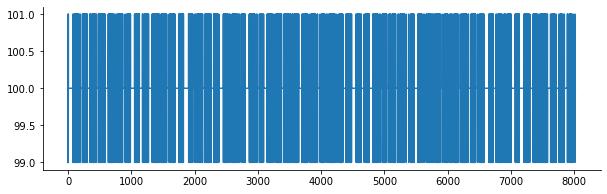

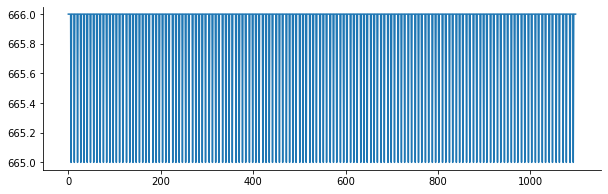

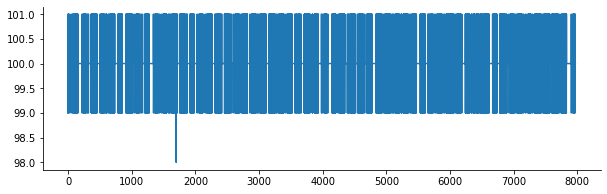

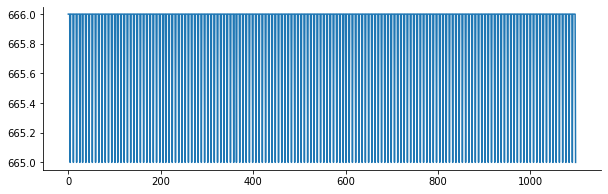

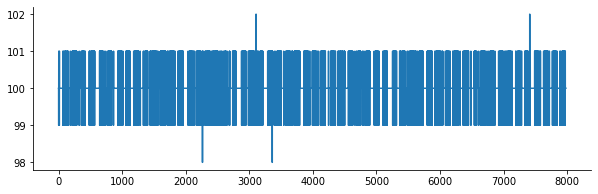

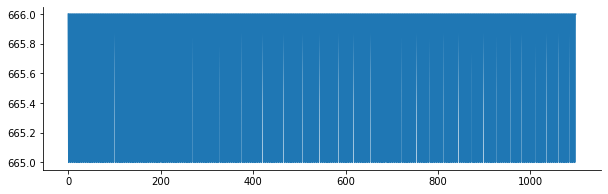

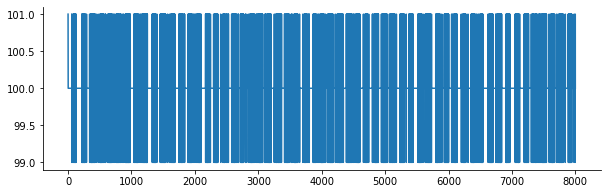

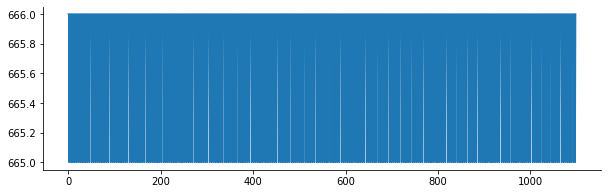

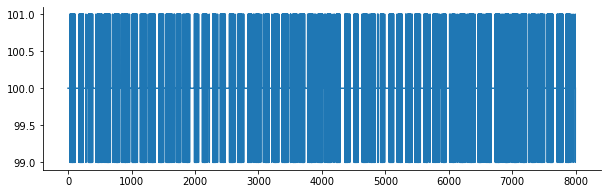

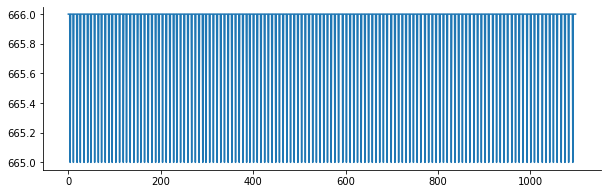

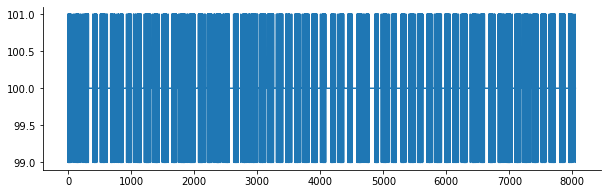

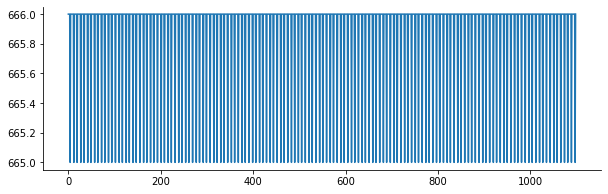

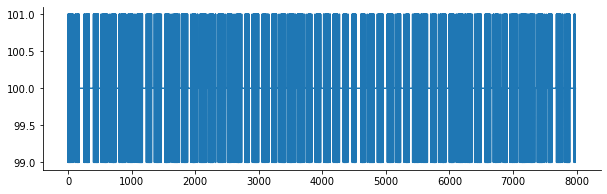

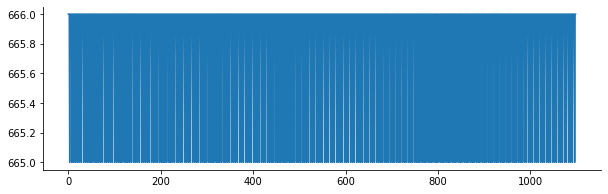

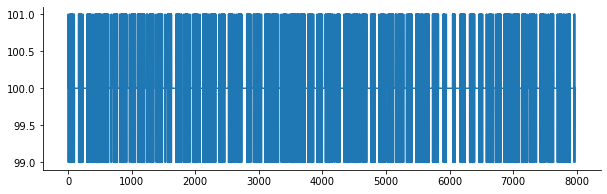

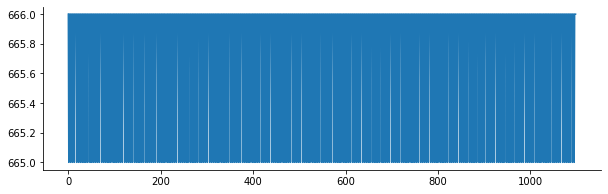

In [ ]:
for trial_index in range(len(image_file_path_sorted)):
  # create AxonRecording object from the class.
  example_recording = AxonRecording(image_file_path_sorted[trial_index],frames_data_file_path_sorted[trial_index],video_data_file_path_sorted[trial_index],outfile_name)

  # create filtered data using the method
  example_recording.filter_ScanImageFile_singleZ()

  # register the GCaMP signals
  example_recording.motion_correction()

  #detect frames for the 2p image and camera, find the match
  example_recording.detect_camera_imaging_frames2()

  #Make the synchronized video
  example_recording.make_synchronized_video_gray()

